# Lab 5: Detecting Breast Cancer using Logistic Regression

## Learning Objectives
* Applying Linear Classification to Breast Cancer Prediction
* Understanding Logistic Regression
* Model Evaluation for Classification

## Outline
1. [Implementing Linear Regression](#1.-Implementing-Logistic-Regression)
    1. [Preparing the Toy Dataset](#Preparing-the-Toy-Dataset)
    2. [Consolidating Model Parameters](#Consolidating-Model-Parameters)
    3. [Computing Class Probabilities](#Computing-Class-Probabilities)
    4. [Fitting the Model](#Fitting-the-Model)
    5. [Making Predictions](#Making-Predictions)
    6. [Visualizing the Result](#Visualizing-the-Result)
2. [Predicting Breast Cancer](#2.-Predicting-Breast-Cancer)
    1. [Understanding the Dataset](#Understanding-the-Dataset)
    2. [Training the Logistic Regression Model](#Training-the-Logistic-Regression-Model)
    3. [Predict and Evaluate Results](#Predict-and-Evaluate-Results)

## Today's Lab
Doctors at the Wash U Medical School need your help in finding a fast, reliable method of detecting the malignancy of breast cancer tumors for their patients. Thankfully, Dr. William H. Wolberg from the University of Wisconsin has provided a dataset of hundreds of `benign` and `malignant` cases at their hospital. By the end of this lab, you will know how to build an accurate classification model to perform this task. We will begin by revising and implementing the logistic regression classifier and then train and test it on the breast cancer dataset. For evaluation we will introduce some new metrics that are specific to classification. 

## 1. Implementing Logistic Regression

An implementation of logistic regression has several components and we will walk through all of them step-by-step. Before we take a look at cancer data, let's take a step back and use a toy dataset for our implementation. Since we will only be considering binary (+1/-1) classification today.

### Preparing the Toy Dataset

In [1]:
from utility.util import load_toy

X, y = load_toy()
y
a =[]
for i in y:
    if i>0:
        a.append(i)
len(a)
y

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

Let's try to visualize the data that we are trying to model.

**Try this!** Create a scatter plot that shows `X` ($x_1$ and $x_2$) and `y` in different colors and with different marker shapes. Include appropriate axes labels, a legend, and a title. Check your plot with your neighbors and a TA (for a quick sanity check). `Hint` You can make use of the `label` keyword argument of any `Matplotlib` plotting function with `plt.legend` to automatically take care of your legend labels.

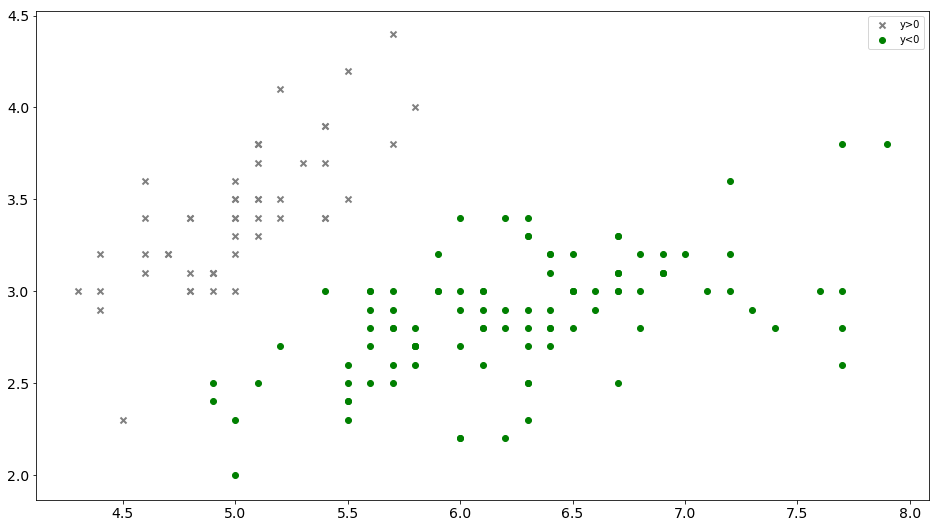

In [2]:
import matplotlib.pyplot as plt
from utility.util import configure_plots

configure_plots()

# your code here
ax1 = plt.scatter(X[y>0,0],X[y>0,1], marker='x', color='gray')
ax2 = plt.scatter(X[y<0,0],X[y<0,1],marker='o', color='green')
plt.legend((ax1, ax2), ('y>0', 'y<0'))
plt.show()

### Consolidating Model Parameters

Before we start we'll apply the trick of consolidating the mdoel parameters $b$ and $w$ as was described in lecture. In our discussions so far we have represented models with the general formula: $$y = wx + b.$$ In this representation, we notate $w$ and $b$ as distinct entities with separate names. However, it is also very common to see all of a models parameters referred to as a single unit called $\theta$, $\beta$, or $w$, amongst other names, depending on the context.

> _For the curious_: In statistics, it is common to see model parameters referred to as $\beta_0$, $\beta_1$, etc.; and, in ML, it is more common to see them referred to as $w_0$, $w_1$, etc.

This is a valid thing to do because the bias or constant term $b$ is really just another parameter of the model. Practically, however, this means that we will need to change the way we define $w$ and $X$ in order to keep the math straight.

The way to do this is by prepending $b$ to our weights $w$ as $w_0$ so that, $$w = [b, w_1, w_2, \ldots] = [w_0, w_1, w_2, \ldots].$$

Accordingly, we must also adjust $X$ in order to keep the math (via dot product) consistent. We can do this by adding a $1$ to each observation so that for each data point, $x_i$, we have $$x_i = [1, x_{i, 0}, x_{i, 1}, \ldots, x_{i, d}].$$

These adjustments result in
$$
\begin{align}
    y_i &= w^\top x_i \\
    &= w_0 + w_1 x_1 + w_2 x_2 + \ldots + w_d x_d \\
    &= b + w_1 x_1 + w_2 x_2 + \ldots + w_d x_d.
\end{align}
$$

Going forward, expect to see more of this notation, but remember that it is the equivalent to our initial notation.

**Try this!** Complete the following function so that it returns `X_aug`, which is `X` augmented with ones.

In [4]:
import numpy as np
def add_intercept(X):
    '''Returns X with ones prepended to each observation'''
    
    # your code here
    ones =np.ones((X.shape[0],1))
   
    X_aug= np.concatenate((ones,X), axis=1)
    assert X.shape[0] == X_aug.shape[0], \
        'Adding an intercept should NOT change the number of observations'
    assert X.shape[1] + 1 == X_aug.shape[1], \
        'Adding an intercept should increase the number of features by exactly 1.'
    
    return X_aug


Your implementation should return `X` with now three columns instead of two, where the first column is one for each data point.

**Try this!** Slice and evaluate the first 5 augmented data inputs from `X_aug`. Is this what you expected to see?

In [5]:
X_aug = add_intercept(X)

# your code here
X_aug[:5]

array([[1. , 5.1, 3.5],
       [1. , 4.9, 3. ],
       [1. , 4.7, 3.2],
       [1. , 4.6, 3.1],
       [1. , 5. , 3.6]])

### Computing Class Probabilities

As you have seen during class, the logistic regression model defines the probability that the label of a data point is `+1` given its features:
$$P(y=+1 \mid x) = \frac{1}{1 + e^{-w^{\top}x}}$$ And, by the laws of probability, the probability that the label of a data point is `-1` is simply the complement, or $$P(y =-1 \mid x) = 1 - P(y=+1 \mid x)$$

Intuitively, the model takes a score $s(x) =-w^{\top}x$ that can be in the range $[-\infty, \infty]$ and interprets it as a probability using the sigmoid function. 

**Try this!** Complete the `sigmoid` function so that it computes $\text{sigmoid}(s)$ using NumPy operations. Note that `s` can be either a scalar or a NumPy array.

In [6]:
def sigmoid(score):
    '''Computes the sigmoid value of s'''
    
    # your code here
    result = 1/(1+np.exp(-score))
    return result

Let's check your implementation by plotting it. If you did everything correctly, the y-axis will be between 0 and 1 and the function will be (point) symmetric with respect to the center point $(0,0.5)$.

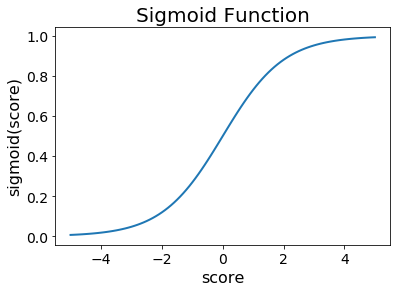

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

xs = np.linspace(-5, 5, 101)
plt.plot(xs, sigmoid(xs))
plt.title('Sigmoid Function')
plt.xlabel('score')
plt.ylabel('sigmoid(score)')
plt.show()

### Fitting the Model

Training the logistic regression model means learning the weights, $w$, by maximizing [**likelihood**](https://en.wikipedia.org/wiki/Likelihood_function). Wikipedia says that "Likelihood describes the plausibility, given specific observed data, of a parameter value of the statistical model which is assumed to describe that data." In other words, a likelihood is a measure of how likely a model parameterized by $w$ could have produced the data $(X, y)$.

The likelihood of _one particular data point_ $(x^*, y^*)$ is given as $L(w \mid x^*, y^*) = P(y=y^* \mid x^*, w)$ such that

$$
P(y^* \mid x^*, w) = \left \{
    \begin{array}{lr}
    \frac{1}{1 + e^{-w^{T}x^*}} \text{ for } y^* = +1\\
    1-\frac{1}{1 + e^{-w^{T}x^*}} \text{ for }  y^* = -1
    \end{array}
    \right .
$$

By the laws of what is called a [_joint probability distribution_](https://en.wikipedia.org/wiki/Joint_probability_distribution) (of independent random variables), the likelihood for the entire training dataset is given as the product of the data-point likelihoods: 
$$L(w \mid  X, y) = \prod_{i=1}^n L(w \mid x_i, y_i).$$

Now, what we want is to find the model parameters that fit our training dataset the _best_. This means we need to look for the model parameters that maximize this likelihood! This is another **optimization problem**, similar to the one we solved for linear regression. However, unlike that of linear regression, this one has no [closed-form](https://en.wikipedia.org/wiki/Closed-form_expression) solution — we have to use numerical optimization to solve it.

The algorithm to solve this is an iterative hill climbing technique also known as [_gradient ascent_](https://en.wikipedia.org/wiki/Gradient_descent) (or _descent_ if you have a minimization problem). 
> **Intuition**:  The algorithm starts with a random set of parameters and then iteratively updates the parameters following the direction of the gradient until the gradient is 0. <br />
> **Challenge**: Check out the implementation we provided for you in `utility/util.py` (After doing the math (which requires _some_ calculus, everything turns out surprisingly simple - like you'll only need "five" lines of code.) 

Let's train a logistic regression model with our Iris data. As we mentioned previously, the optimization process for finding $w$ is a bit out of scope for our class, so instead of implementing it together, we have provided our own implementation, `fit`, for you to use.

**Try this!** Create a train/test split of `X_aug` and `y` (using the 80:20 ratio and a `random_state` of 3) and then use `fit` to train the model. Store the output of `fit` in the variable `w`.

In [8]:
from utility.util import optimize_logistic as fit
from sklearn.model_selection import train_test_split

# your code here
X_train, X_test, y_train, y_test = train_test_split(X_aug, y, test_size=0.2, random_state=3)
w= fit(X_train, y_train)

### Making Predictions

Given weights $w$ and points $X$ we can make predictions by computing $P(y=+1 | x)$. With this probability and a threshold, we can produce a predicted label such that if $P(y=+1 | x) > \text{threshold}$.

**Try this!** Complete the `predict_probability` function below so that it computes $P(y=+1 | x)$.

In [77]:
def predict_probability(X, w):
    '''
    Computes the predicted probability of points in X given model parameters W
    '''
    # your code here
    #wt = np.transpose(w)
    p = sigmoid(np.dot(X,w))
    
    assert np.all(0 <= p) and np.all(p <= 1), 'Probability must be between 0 and 1'
    
    return p

**Try this!** Complete the `predict` function below so that it computes the predicted `labels` of points in `X` given parameters `w`. The threshold is provided as an argument to the function. Make sure that your labels are either `+1` or `-1`. 

In [74]:
def predict(X, w, threshold=0.5):
    '''
    Given the inputs X and model paramters w, turns the probability 
    of being +1 into a hard label using the threshold (default = 0.5)
    '''
    assert np.all(X[:, 0] == 1), 'X needs to be augmented with a column of ones!'
    
    N = X.shape[0]
    labels=[]
    # your code here
    for x in X:
        if predict_probability(x, w) < threshold:
            labels.append(-1)
        else:
            labels.append(1)
    labels = np.array(labels)     
    assert isinstance(labels, np.ndarray), 'Labels should be returned as a NumPy array'
    assert labels.shape[0] == N, 'There should be the same number of labels as their are points in X'
    assert np.all(np.unique(labels) == np.array([-1, 1])), 'Labels should be either +1 or -1'
    
    return labels

To test your implementation use the following paramters, provided by an _oracle_. Make sure you understand what each of them corresponds to. Your predictions for the first 4 data points should positive and the 5th data point should be predicted negative. 

In [75]:
sample_w = np.array([-0.09,  0.58, -0.80])
predict(X_aug[:5,:], sample_w)

array([ 1,  1,  1,  1, -1])

Before we move on, let's take some time to consider how we might decide what decision threshold to use.

**Write-up!** Why does it make sense to use 0.5? Can you think of any scenarios where you might want to use a different threshold?

### Visualizing the Result
We can now visualize the decision boundary and the prediction results. In the cell below, we have provided the code for scattering the training set as well as plotting the decision boundary. Fill in the scatter plots for the testing set in addition to adding plot description components.

**Try this!** Create a scatter plot that shows _setosa_ and _non-setosa_ in different colors and with different marker shapes for the testing sets. We have provided `y_pred` which contains the predicted labels for the points in `X_test`. Include appropriate axes labels, a legend, and a title. Check your plot with your neighbors and a TA (for a quick sanity check). `Hint` you will make 4 calls to `plt.scatter`.

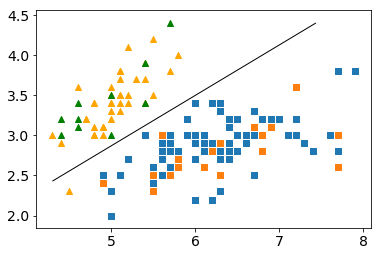

In [78]:
y_pred = predict(X_test, w)

# training data scatters
plt.scatter(X_train[y_train > 0, 1], X_train[y_train > 0, 2], marker='^', color='orange', label='Training Setosa (+1)')
plt.scatter(X_train[y_train < 0, 1], X_train[y_train < 0, 2], marker='s', label='Training Other (-1)')

# your code here
plt.scatter(X_test[y_pred > 0, 1], X_test[y_pred > 0, 2], marker='^', color='green', label='Training Setosa (+1)')
plt.scatter(X_test[y_pred< 0, 1], X_test[y_pred < 0, 2], marker='s', label='Training Other (-1)')


# Plot the decision boundary (pretty complicated plot - feel free to ignore)
A, B = np.meshgrid(np.linspace(X_aug[:, 1].min(), X_aug[:, 1].max()),
                   np.linspace(X_aug[:, 2].min(), X_aug[:, 2].max()))
xs = add_intercept(np.c_[A.ravel(), B.ravel()])
ps = predict_probability(xs, w).reshape(A.shape)
plt.contour(A, B, ps, [0.5], linewidths=1, colors='black');

## 2. Predicting Breast Cancer
Since all of this looks pretty good now, we can trun to our actual application for today: predicitng whether a patient has breas cancer or not. First, let's take a quick look at the data from the University of Wisconsin. Each data point contains information about the breast cancer cells of a single patient derived from a digitized image of a fine needle aspirate (FNA) of a breast mass, similar to those: 

![MoMA](utility/pics/fna.jpg)

Note that we do not have the image data, but the features capture the cell shapes and we also have the diagnosis (either `malignant` or `benign`), which we will treat as the class label.

### Understanding the Dataset

Let's take a look at what we have.

In [60]:
from sklearn.datasets import load_breast_cancer

cancer_data = load_breast_cancer()

Let's take a second to explore `data`.

**Try this!** In the following cell, evaluate each of the fields in data.

In [85]:
# your code here
cancer_data.data

array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
        1.189e-01],
       [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
        8.902e-02],
       [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
        8.758e-02],
       ...,
       [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
        7.820e-02],
       [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
        1.240e-01],
       [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
        7.039e-02]])

**Write-up!** Just for safe-keeping, how many data points are there in this dataset? How many features? What are the names of the features? What are the names of the classes and how are they encoded in the labels?

Now that we are familiar with what the data looks like, let's pull out what we need from it.

**Try this!** Pull out the input data `X` and label (classification) data `y` from `data`. Make sure that the labels in `y` are either `+1` for `malignant` or `-1` for `benign` tumors.

In [95]:
# your code here
X = cancer_data.data
y = cancer_data.target
y[y==0]=-1
assert np.all(np.unique(y) == np.array([-1, 1]))
N, d = X.shape
f'There are {N} data points with {d} features each.'

'There are 569 data points with 30 features each.'

Let's plot the distribution of the classes in the dataset.

[212 357]
[-1  1]


Text(0.5,1,'Class Distribution - Breast Cancer Dataset')

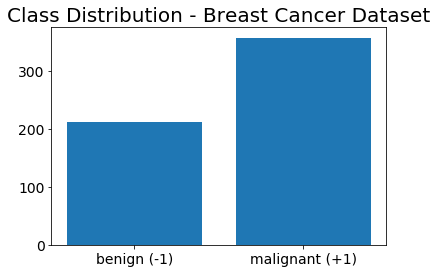

In [96]:
classes, counts = np.unique(y, return_counts=True)

print(counts)
print(classes)

plt.bar(['benign (-1)', 'malignant (+1)'], counts)
plt.title('Class Distribution - Breast Cancer Dataset')

**Write-up!** What do you notice?

### Training the Logistic Regression Model

Now, you will train the classifier and then evaluate its performance. 

**Try this!** First, let's create the train-test split (use `random_state=42`). However, as you hopefully noticed above, our dataset does not have a balanced class distribution. So, when creating the train/test (in the usual 80/20 ratio) split use the argument `stratify=y` to get the same class distribution in the training and the testing set. Remember to augment your data with `add_intercept`.
> **Discuss with your neighbors:** Why is this relevant?

[170 285]
[-1  1]


Text(0.5,1,'Training Class Distribution')

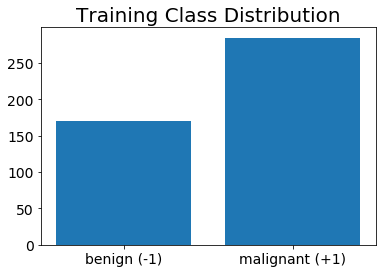

In [98]:
from sklearn.model_selection import train_test_split

# your code here
X_aug = add_intercept(X)
X_train, X_test, y_train, y_test = train_test_split(X_aug, y, test_size=0.2, random_state=42,stratify=y)

assert X_train.shape[1] == X.shape[1] + 1, 'Remeber to augment your data'

classes, counts = np.unique(y_train, return_counts=True)
print(counts)
print(classes)
plt.bar(['benign (-1)','malignant (+1)'],counts)
plt.title('Training Class Distribution')

**Try this!** In the cell below, use `fit` with `X_train` and `y_train` and store the resulting weights in `w`.

In [100]:
# your code here
w = fit(X_train, y_train)
print(w)

[ 1.04801851  7.532004    1.11976313  8.68757649 -0.28509995 -0.25641221
 -1.16745969 -1.65162014 -0.68822009 -0.50395798 -0.09080377  0.20589489
  2.83793725 -0.6203683  -1.62786161 -0.02967963 -0.23199691 -0.35804248
 -0.09556968 -0.13190021 -0.0176006   7.16382506 -4.24405142 -4.57324318
 -0.26390471 -0.51965584 -3.61742476 -4.58490368 -1.37917909 -1.48165368
 -0.32851387]


### Predict and Evaluate Results
Use the classifier to predict the class labels on the test data.

**Try this** Use `predict` with `X_test` and weights `w` to produce predictions `y_pred`.

In [119]:
# your code here
y_pred = predict(X_test,w)
y_pred.shape

(114,)

Next, let's count the mistakes and compute the error rate (out of 100%). 

**Try this!** Complete the `accuracy` function below so that it computes the accuracy of the `predictions` relative to the `labels`.

In [128]:
def accuracy(predictions, labels):
    '''Computes the accuracy of the predictions'''
    
    N = labels.shape[0]
    
    # your code here
    right=[]
    result=0
    for i in range(predictions.shape[0]-1):
        if predictions[i] == labels[i]:
            right.append(1)
    resutlt= float(sum(right)/N)
    return result

In [3]:
f'Accuracy: {accuracy(y_pred, y_test) * 100:0.5}%'

NameError: name 'accuracy' is not defined

This looks pretty good - we did not make a lot of mistakes. However, let's analyze this more closely. For classification problems we can instead of just counting mistakes look at which kind of mistakes we made. 

**Write-up!** What are the two different kinds of mistakes we can make for breast cancer prediction?

#### Confusion Matrix
Recall that in `Lab3` we counted _false positives_ and _false negatives_. Relate those measures to our application and your answer above. Now, let's compute those, in fact, let's compute the entire confusion matrix. `scikit-learn` comes with a metric that does that for us.   

In [126]:
from sklearn.metrics import confusion_matrix
classes = [+1, -1]
class_names = ['malignant (+1)', 'benign (-1)']
cnf_matrix = confusion_matrix(y_test, y_pred, labels=classes)
print(cnf_matrix)

[[68  4]
 [ 5 37]]


We can also visualize this to make the results easier to interpret: 

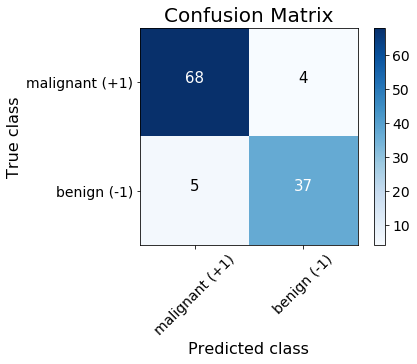

In [127]:
# Plot the color matrix
plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

# Label the axes
classes = [+1, -1]
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.ylabel('True class')
plt.xlabel('Predicted class')

# Print the counts
thresh = cnf_matrix.max() / 2.
for i in range(cnf_matrix.shape[0]):
    for j in range(cnf_matrix.shape[1]):
        plt.text(j, i, format(cnf_matrix[i, j], 'd'), FontSize='15',
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > thresh else "black")

plt.title('Confusion Matrix')
plt.show()

**Write-up!** Discuss the results with your neighbors. Are you happy with your results? What can you learn from this visualization? 